# Twitter Sentiment Analysis
En este notebook vas a ver un ejemplo de los procesos necesarios para realizar un análisis de sentimientos sobre Tweets. Para ello tendremos que seguir los siguientes pasos:
1. Conseguir un Corpus: no es más que una base de datos de texto etiquetado
2. Limpiar los datos
3. Entrenar un modelo con el corpus
4. Atacar a la API de Twitter
5. Predecir los nuevos Tweets

**Estos programas son muy útiles en campañas de marketing, para monitorizar el lanzamiento de un nuevo producto, realizar seguimiento en Twitter de eventos, o simplemente tener monitorizadas ciertas cuentas o hashtags para tener un programa de análisis real time.**

## 1. Corpus
Para conseguir el corpus tendremos que registrarnos en la [página del TASS](http://tass.sepln.org/tass_data/download.php), que se trata de una asociación de análisis semántico que encargada de recopilar texto y mantenerlo etiquetado. 

Para datasets en ingles lo tenemos más fácil ya que con librerías como [TextBlob](https://textblob.readthedocs.io/en/dev/) podemos predecir directamente la polaridad del Tweet, con modelos ya preentrenados. En el caso del castellano necesitamos acudir a un corpus etiquetado para entrenar nuestro modelo.

Registrate en el TASS y accede a sus corpus a través de un link que te llegará al correo tras el registro.

![imagen](img/tass_register.png)


Una vez estes registrado, descárgate el corpus de tweets en español de entrenamiento. En este punto lo ideal es coger un corpus que se adapte lo máximo posible a los tipos de tweets que intentamos predecir, es decir, si queremos predecir tweets sobre política, procurar elegir un corpus que tenga vocabulario de política.

En este notebook se va a elegir un corpus genérico con no demasiados registros para aligerar la limpieza y entrenamiento de los modelos.

![imagen](img/download_train_spanish.png)

### Importamos librerias

In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import seaborn as sns

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### Leemos el dataset

In [2]:
tree = ET.parse('dataNLP/general-train-tagged.xml')
root = tree.getroot()

In [3]:
raw_dict = {
    'User': [],
    'Content': [],
    'Date': [],
    'Lang': [],
    'Polarity': [],
    'Type': []
}

for i in root.iter('tweet'):
    user = i.find('user').text
    content = i.find('content').text
    date = i.find('date').text
    lang = i.find('lang').text
    polarity = i.find('sentiments').find('polarity').find('value').text
    tweet_type = i.find('sentiments').find('polarity').find('type').text
    
    raw_dict['User'].append(user)
    raw_dict['Content'].append(content)
    raw_dict['Date'].append(date)
    raw_dict['Lang'].append(lang)
    raw_dict['Polarity'].append(polarity)
    raw_dict['Type'].append(tweet_type)
    
df = pd.DataFrame(raw_dict)
print(df.shape)

df.head()

(7219, 6)


,User,Content,Date,Lang,Polarity,Type
0,ccifuentes,"Salgo de #VeoTV , que día más largoooooo...",2011-12-02T00:47:55,es,NONE,AGREEMENT
1,CarmendelRiego,@PauladeLasHeras No te libraras de ayudar me/n...,2011-12-02T00:49:40,es,NEU,DISAGREEMENT
2,CarmendelRiego,@marodriguezb Gracias MAR,2011-12-02T00:57:40,es,P,AGREEMENT
3,mgilguerrero,"Off pensando en el regalito Sinde, la que se v...",2011-12-02T02:33:37,es,N+,AGREEMENT
4,paurubio,Conozco a alguien q es adicto al drama! Ja ja ...,2011-12-02T02:59:03,es,P+,AGREEMENT


### Columna de polaridad

In [4]:
# Vemos los valores unicos de la columna de polaridad
df.Polarity.unique()

array(['NONE', 'NEU', 'P', 'N+', 'P+', 'N'], dtype=object)

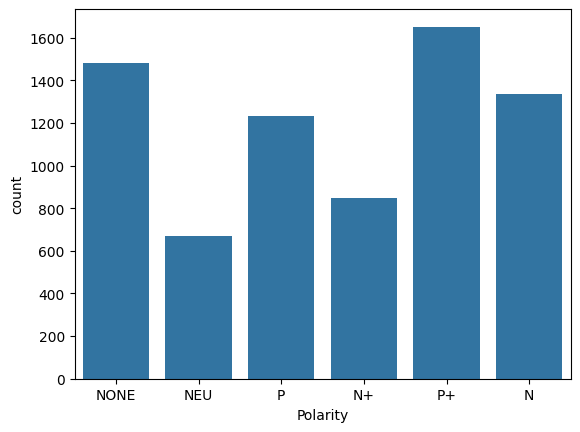

In [5]:
sns.countplot(x = 'Polarity', data=df);

#### Columna de tipo

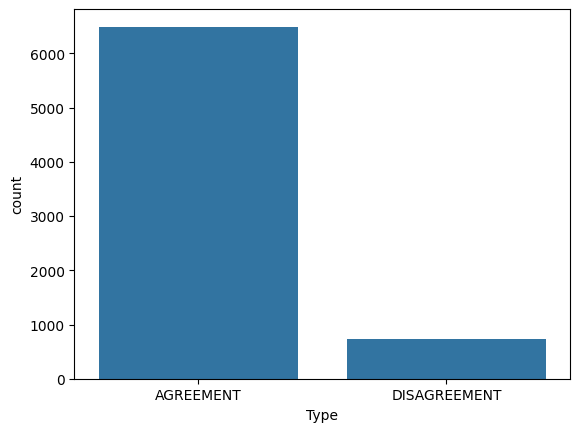

In [6]:
sns.countplot(x = 'Type', data=df);

## 2. Limpieza de datos
#### Polaridad
Vamos a clasificar los Tweets como buenos o malos, por lo que haremos la siguiente agrupación de la polaridad

In [7]:
def polaridad_fun(x):
    if x in ('P', 'P+'):
        return 0
    elif x in ('N', 'N+'):
        return 1

In [8]:
# Nos cargamos los NONE y los neutros
df = df[~df['Polarity'].isin(['NONE', 'NEU'])]
df['Polarity'].unique()

array(['P', 'N+', 'P+', 'N'], dtype=object)

In [9]:
# Pasamos la columna a 1s y 0s. Y el tipo
df['Polarity'] = df['Polarity'].apply(polaridad_fun)
df['Polarity'].unique()

array([0, 1], dtype=int64)

#### Idioma
Nos quedamos con los tweets en español. Si no tuviésemos esa columna podríamos acudir a librerías como `langid` o `langdetect`.

In [ ]:
# Filtramos los tweets en español
df = df[df['Lang'] == 'es']

In [ ]:
# Vemos con cuantos registros nos hemos quedado despues del filtrado
df.shape

#### Duplicados

In [ ]:
# Eliminamos los duplicados
df.drop_duplicates(subset = 'Content', inplace=True)
df.shape

#### Signos de puntuación
Eliminamos signos de puntuación: puntos, comas, interrogaciones, paréntesis

In [ ]:
df['Content'].head()

In [ ]:
import re

signos = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\¿)|(\@)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")

def signs_tweets(tweet):
    return signos.sub('', tweet.lower())

df['Content'] = df['Content'].apply(signs_tweets)
df['Content'].head()

#### Eliminamos links

In [ ]:
def remove_links(df):
    return " ".join(['{link}' if ('http') in word else word for word in df.split()])

df['Content'] = df['Content'].apply(remove_links)

#### Otros
Podríamos hacer un preprocesado mucho más fino:
1. Hashtags
2. Menciones
3. Abreviaturas
4. Faltas de ortografía
5. Risas

## 3. Modelo
Para montar el modelo tendremos que seguir los siguientes pasos
1. Eliminamos las stopwords
2. Aplicamos un stemmer, SnowBall por ejemplo

#### Stopwords

In [ ]:
from nltk.corpus import stopwords

spanish_stopwords = stopwords.words('spanish')

In [ ]:
def remove_stopwords(df):
    return " ".join([word for word in df.split() if word not in spanish_stopwords])

In [ ]:
df['Content'] = df['Content'].apply(remove_stopwords)
df.head()

#### Stemmer

In [ ]:
from nltk.stem.snowball import SnowballStemmer

def spanish_stemmer(x):
    stemmer = SnowballStemmer('spanish')
    return " ".join([stemmer.stem(word) for word in x.split()])

df['Content'] = df['Content'].apply(spanish_stemmer)
df['Content'].head()

#### Seleccionamos columnas
Nos quedamos con las columnas que nos interesan para el modelo

In [ ]:
df = df[['Content', 'Polarity']]

In [ ]:
df.to_csv('dataNLP/output/data_processed.csv')

#### Vectorizamos el dataset

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,2))

#### Montamos Pipeline
Modelos que suelen funcionar bien con pocas observaciones y muchas features son la Regresión logística el LinearSVC o Naive Bayes.

In [ ]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('vect', vectorizer),
    ('cls', LogisticRegression())
])

parameters = {
    'vect__max_df': (0.5, 1 , 1.9),
    'vect__min_df': (5, 10, 20,50),
    'vect__max_features': (500, 1000),
    "cls__penalty": ["l1","l2"], # Regularizaciones L1 y L2.
    "cls__C": [0.1, 0.5, 1.0, 5.0] # Cuanta regularizacion queremos

}

grid_search = GridSearchCV(pipeline,
                          parameters,
                          cv = 5,
                          n_jobs = -1,
                          scoring = 'accuracy')

#### Entrenamos

In [ ]:
grid_search.fit(df['Content'], df['Polarity'])

In [ ]:
print("Best params:", grid_search.best_params_)
print("Best acc:", grid_search.best_score_)
print("Best model:", grid_search.best_estimator_)

In [ ]:
grid_search.best_estimator_['cls']

#### Guardamos el modelo

In [ ]:
import pickle

with open('dataNLP/output/finished_model.model', "wb") as archivo_salida:
    pickle.dump(grid_search.best_estimator_, archivo_salida)

## 4. Predicciones
Realizar una predicción con un tweet que escojas

In [ ]:
with open('dataNLP/output/finished_model.model', "rb") as archivo_entrada:
    pipeline_importada = pickle.load(archivo_entrada)

In [ ]:
pipeline_importada

#### Leemos el pipeline con el modelo

In [ ]:
text = pd.Series('El bombardeo de #Gernika por parte de la aviación nazi y fascista fue uno de los episodios más cruentos de la Guerra Civil. 85 años después, recordamos este día y a todas sus víctimas. Porque la memoria es imprescindible para seguir construyendo una sociedad democrática y en paz.')
test_clean = pd.DataFrame(text, columns=['content'])

# Signos de puntuacion
test_clean['content_clean'] = test_clean['content'].apply(signs_tweets)

# Eliminamos links
test_clean['content_clean'] = test_clean['content_clean'].apply(remove_links)

# Nos cargamos stopwords
test_clean['content_clean'] = test_clean['content_clean'].apply(remove_stopwords)

# Aplicamos el Stemmer
test_clean['content_clean'] = test_clean['content_clean'].apply(spanish_stemmer)

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
test_clean

#### Predicciones de test

In [ ]:
test_clean['content_clean']

In [ ]:
predictions = pipeline_importada.predict(test_clean['content_clean'])
test_clean['Polarity'] = pd.Series(predictions)
test_clean

In [ ]:
predictions = pipeline_importada.predict_proba(test_clean['content_clean'])
test_clean['Polarity_Pos'] = pd.Series(predictions[0][0])
test_clean['Polarity_Neg'] = pd.Series(predictions[0][1])
test_clean

## 5. Predicciones con API (EXTRA)
#### API de Twitter
Lo primero que tenemos que hacer es conseguir nuevos Tweets. Para ello:
1. Nos registramos en la [web de desarrolladores de Twitter](https://developer.twitter.com/en/apply-for-access)
2. Bajamos el paquete `tweepy` para atacara  la API de Twitter
3. Buscamos un Hashtag de tendencia
4. Nos logamos y monitorizamos el hastag
5. Aplicamos la limpieza a los Tweets
6. Predecimos la polaridad

In [ ]:
# !pip install tweepy

In [ ]:
# import tweepy  
# import time
# import csv

# import json

# with open('./credentials.json') as f:
#     credentials = json.load(f)
    
    
# # Credenciales de la web de desarroladores
# access_token = credentials['access_token']  
# access_token_secret = credentials['access_token_secret']  
# consumer_key = credentials['consumer_key']
# consumer_secret = credentials['consumer_secret'] 

# # Nos autenticamos en la API
# try:
#     auth = tweepy.OAuthHandler(consumer_key, consumer_secret)  
#     auth.set_access_token(access_token, access_token_secret)  
#     api = tweepy.API(auth,wait_on_rate_limit=True)
#     print("Authentication OK")
# except:
#     print("Error during authentication")

In [ ]:
raw_dict = {
    'author_name': [],
    'created_at': [],
    'content': [],
    'author_description': [],
    'author_followers_count': [],
    'author_profile_image_url': [],
    'author_location': [],
    'author_profile_background_image_url': [],
    'author_notifications': [],
    'geo': [],
    'coordinates': [],
    'entities': [],
    'place': []
}

# https://docs.tweepy.org/en/latest/api.html#search-methods

cursor = tweepy.Cursor(api.search,
                      q = "#lapalma",
                      lang = "es",
                      since = "2021-09-20").items(50)

for tweet in cursor:
    
    raw_dict['author_name'].append(tweet.author.name)
    raw_dict['created_at'].append(tweet.created_at)
    raw_dict['content'].append(tweet.text)
    raw_dict['author_description'].append(tweet.author.description)
    raw_dict['author_followers_count'].append(tweet.author.followers_count)
    raw_dict['author_profile_image_url'].append(tweet.author.profile_image_url)
    raw_dict['author_location'].append(tweet.author.location)
    raw_dict['author_profile_background_image_url'].append(tweet.author.profile_background_image_url)
    raw_dict['author_notifications'].append(tweet.author.notifications)
    raw_dict['geo'].append(tweet.geo)
    raw_dict['coordinates'].append(tweet.coordinates)
    raw_dict['entities'].append(tweet.entities)
    raw_dict['place'].append(tweet.place)
    

test = pd.DataFrame(raw_dict)
test.head()